## Carregamento de libs e dados

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from random import randint

data = pd.read_csv('diabetes_dataset.csv')

print("##### INFO #####")
print(data.info())

print("\n##### STATS #####")
print(data.describe())

##### INFO #####
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               572 non-null    int64  
 1   Glucose                   567 non-null    float64
 2   BloodPressure             537 non-null    float64
 3   SkinThickness             345 non-null    float64
 4   Insulin                   198 non-null    float64
 5   BMI                       561 non-null    float64
 6   DiabetesPedigreeFunction  572 non-null    float64
 7   Age                       572 non-null    int64  
 8   Outcome                   572 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 40.3 KB
None

##### STATS #####
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   572.000000  567.000000     537.000000     345.000000  198.000000   
mean      4.106643  121.647266      73.150838  

## Definições de funções

In [2]:
def trainTestReport(df, train_fact):
    
    n = len(df)
    n_train = int(train_fact * n)
    n_test = n - n_train
    
    df_train = df[:n_train]
    df_test = df[-n_test:]
    
    feature_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    
    X = df_train[feature_cols]
    Y = df_train.Outcome
    
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(X, Y)
    
    Y_pred = neigh.predict(df_test[feature_cols])
    
    acc = metrics.accuracy_score(df_test.Outcome, Y_pred)
    pre = metrics.precision_score(df_test.Outcome, Y_pred)
    rec = metrics.recall_score(df_test.Outcome, Y_pred)
    
    return acc, pre, rec

In [3]:
def sliceTrainAndTest(df, train_fract, var_to_mod=None, varModFunct=None, lower_cut=-1, upper_cut=-1):
    
    # Por segurança, trabalhamos com uma cópia.
    dfc = df.copy()
    
    # Embaralha todo o dataframe (fraction = 1), usando seed 42 para reproducibilidade.
    #df_shuf = df.sample(frac=1, random_state=42)
    df_shuf = dfc.sample(frac=1)
    
    # Cortes dos dois pedaços do dataframe que vamos usar para comparar modificações.
    n = len(df_shuf)
    n1 = int(n/2)
    n2 = n - n1
    
    # df_base será nossa referência. Única modificação será passar um dataframe.dropna() e então treinar e testar.
    df_base = df_shuf[:n1]
    
    # df_mod será nossa cobaia. Na coluna definida por var_to_mod vamos aplicar a função varModFunct() e então treinar e testar.
    df_mod = df_shuf[-n2:]
    
    if lower_cut > -1:
        df_mod = df_mod[(df_mod[var_to_mod] is np.nan) or (df_mod[var_to_mod] >= lower_cut)]
    
    if upper_cut > -1:
        df_mod = df_mod[(df_mod[var_to_mod] is np.nan) or (df_mod[var_to_mod] <= upper_cut)]
    
    """ DF Base - Limpeza e treino com fatia de referência """
    df_base = df_base.dropna()
    base_acc, base_pre, base_rec = trainTestReport(df_base, train_fract)
    
    """ DF Modificado - Aplica varModFunc() em var_to_mod """
    if var_to_mod is not None:
        
        df_mod[var_to_mod] = df_mod[var_to_mod].apply(lambda x: varModFunct(x))
        df_mod = df_mod.dropna()
        mod_acc, mod_pre, mod_rec = trainTestReport(df_mod, train_fract)
        
        return {'base':{ 'acc': base_acc, 'pre': base_pre, 'rec': base_rec },
                'mod' :{ 'acc': mod_acc,  'pre': mod_pre,  'rec': mod_rec}}
    
    return { 'acc': base_acc, 'pre': base_pre, 'rec': base_rec }
    

In [4]:
def acumulateTrainTestRuns(df, train_fract, var_to_mod, varModFunct, lower_cut, upper_cut, runs=100):
    
    BaseAcc = []
    BasePre = []
    BaseRec = []
    
    ModAcc = []
    ModPre = []
    ModRec = []
    
    for i in range(0, runs):
        results = sliceTrainAndTest(df, train_fract, var_to_mod, varModFunct, lower_cut, upper_cut)
        BaseAcc.append(results['base']['acc'])
        BasePre.append(results['base']['pre'])
        BaseRec.append(results['base']['rec'])
        ModAcc.append(results['mod']['acc'])
        ModPre.append(results['mod']['pre'])
        ModRec.append(results['mod']['rec'])
    
    df_results = pd.DataFrame({
        'Base Accuracy': BaseAcc,
        'Mod Accuracy': ModAcc,
        'Base Precision': BasePre,
        'Mod Precision': ModPre,
        'Base Recall': BaseRec,
        'Mod Recall': ModRec
    })
    
    return df_results

In [5]:
def boundedRandomGen(x, min_val, max_val):
    if pd.isna(x):
        return randint(min_val, max_val)
    return x;

## Melhorias

### Insulina

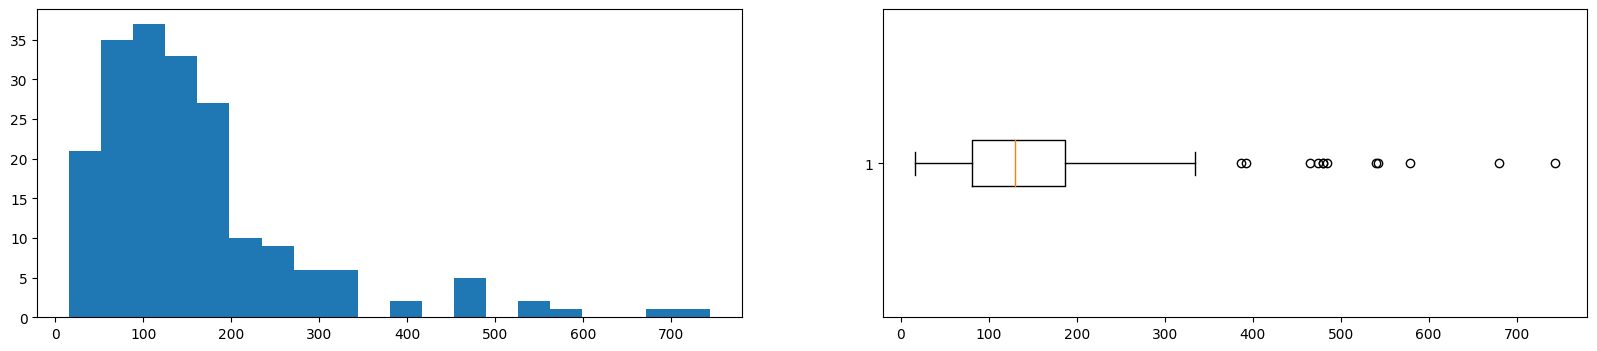

In [6]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(ncols=2, figsize=(20, 4))

axes[0].hist(dft.Insulin, bins=20)
axes[1].boxplot(dft.Insulin, vert=False)

plt.show()

In [7]:
data.describe()['Insulin']

count    198.000000
mean     156.934343
std      119.066934
min       16.000000
25%       77.500000
50%      129.500000
75%      185.000000
max      744.000000
Name: Insulin, dtype: float64

In [8]:
df_insulin = acumulateTrainTestRuns(data, 0.8, 'Insulin', lambda x: boundedRandomGen(x, 50, 350), lower_cut=-1, upper_cut=-1, runs=500)
df_insulin.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.679218,0.686920,0.535791,0.544214,0.469481,0.469632
std,0.097675,0.074901,0.214921,0.164054,0.204621,0.164837
min,0.315789,0.468750,0.000000,0.000000,0.000000,0.000000
25%,0.619048,0.636364,0.400000,0.444444,0.333333,0.363636
50%,0.684211,0.685714,0.500000,0.545455,0.500000,0.500000
75%,0.750000,0.735294,0.666667,0.642857,0.600000,0.571429
max,0.944444,0.885714,1.000000,1.000000,1.000000,1.000000


### Espessura da pele

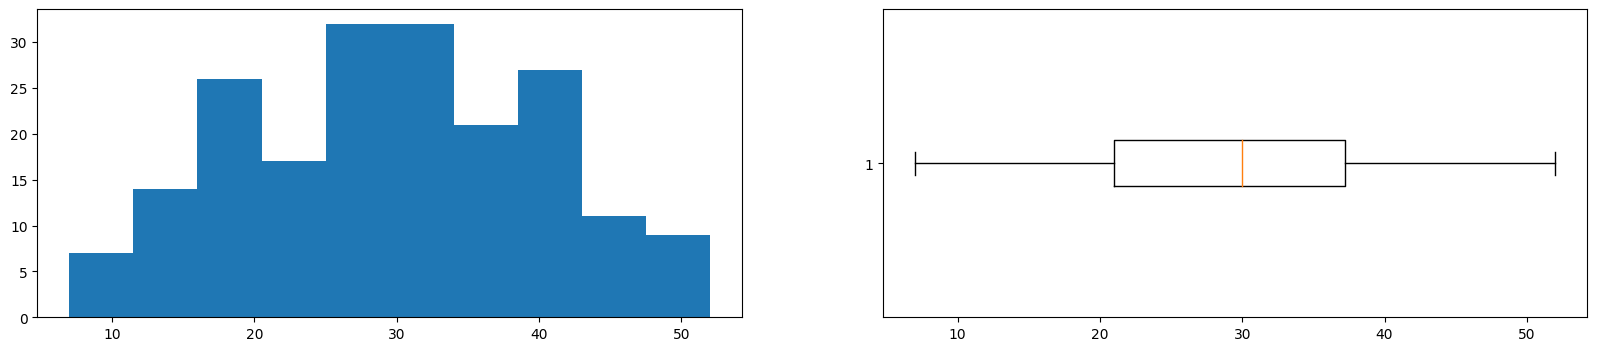

In [9]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(ncols=2, figsize=(20, 4))

axes[0].hist(dft.SkinThickness, bins=10)
axes[1].boxplot(dft.SkinThickness, vert=False)

plt.show()

In [10]:
data.describe()['SkinThickness']

count    345.000000
mean      29.356522
std       10.433503
min        7.000000
25%       22.000000
50%       30.000000
75%       36.000000
max       99.000000
Name: SkinThickness, dtype: float64

In [11]:
df_skin = acumulateTrainTestRuns(data, 0.8, 'SkinThickness', lambda x: boundedRandomGen(x, 10, 50), -1, -1, 500)
df_skin.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.677508,0.672442,0.527502,0.535437,0.479727,0.468921
std,0.099303,0.100146,0.221737,0.211251,0.227246,0.206148
min,0.400000,0.333333,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.600000,0.400000,0.400000,0.333333,0.333333
50%,0.684211,0.681818,0.500000,0.500000,0.500000,0.500000
75%,0.750000,0.750000,0.666667,0.666667,0.666667,0.600000
max,0.904762,1.000000,1.000000,1.000000,1.000000,1.000000


### Pressão sanguínea

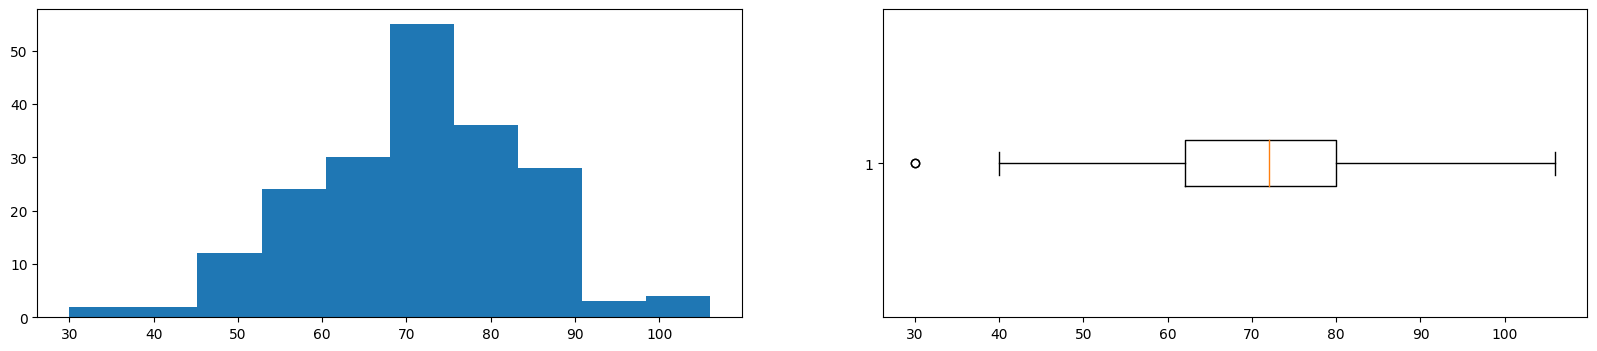

In [12]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(ncols=2, figsize=(20, 4))

axes[0].hist(dft.BloodPressure, bins=10)
axes[1].boxplot(dft.BloodPressure, vert=False)

plt.show()

In [13]:
data.describe()['BloodPressure']

count    537.000000
mean      73.150838
std       12.347184
min       30.000000
25%       65.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

In [14]:
df_bp = acumulateTrainTestRuns(data, 0.8, 'BloodPressure', lambda x: boundedRandomGen(x, 45, 110), 40, 120, 500)
df_bp.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.679712,0.680616,0.532817,0.543986,0.491716,0.472116
std,0.107788,0.104333,0.213808,0.230571,0.225586,0.219487
min,0.368421,0.350000,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.611111,0.400000,0.400000,0.333333,0.333333
50%,0.684211,0.684211,0.500000,0.500000,0.500000,0.477273
75%,0.761905,0.750000,0.666667,0.675000,0.666667,0.643939
max,0.950000,0.947368,1.000000,1.000000,1.000000,1.000000


### IMC

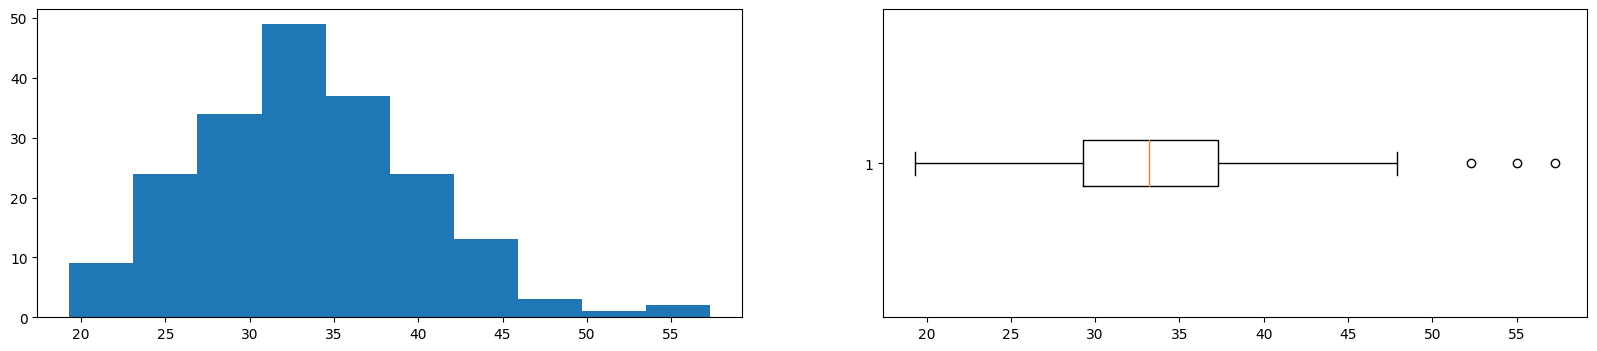

In [15]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(ncols=2, figsize=(20, 4))

axes[0].hist(dft.BMI, bins=10)
axes[1].boxplot(dft.BMI, vert=False)

plt.show()

In [16]:
data.describe()['BMI']

count    561.000000
mean      32.327629
std        6.735437
min       18.200000
25%       27.500000
50%       32.000000
75%       36.600000
max       57.300000
Name: BMI, dtype: float64

In [17]:
df_bmi = acumulateTrainTestRuns(data, 0.8, 'BMI', lambda x: boundedRandomGen(x, 20, 50), -1, 50, 500)
df_bmi.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.676797,0.694862,0.533162,0.569775,0.485349,0.519025
std,0.103636,0.098823,0.212314,0.217831,0.217689,0.222731
min,0.277778,0.368421,0.000000,0.000000,0.000000,0.000000
25%,0.606522,0.631579,0.400000,0.428571,0.333333,0.375000
50%,0.684211,0.700000,0.500000,0.571429,0.500000,0.500000
75%,0.750000,0.761905,0.666667,0.714286,0.635417,0.666667
max,0.950000,0.952381,1.000000,1.000000,1.000000,1.000000


### Glucose

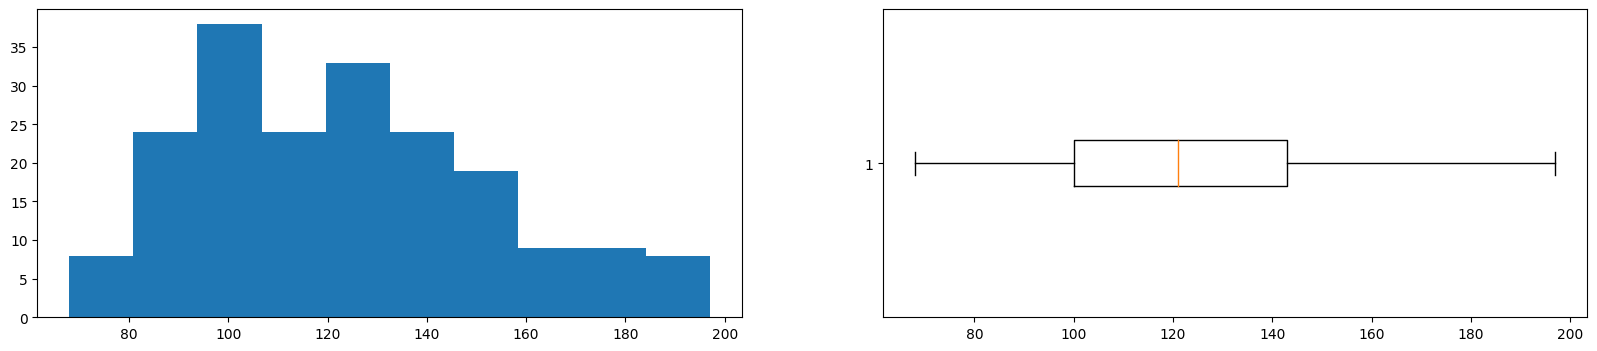

In [18]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(ncols=2, figsize=(20, 4))

axes[0].hist(dft.Glucose, bins=10)
axes[1].boxplot(dft.Glucose, vert=False)

plt.show()

In [19]:
data.describe()['Glucose']

count    567.000000
mean     121.647266
std       30.132084
min       44.000000
25%      100.000000
50%      117.000000
75%      140.000000
max      199.000000
Name: Glucose, dtype: float64

In [20]:
df_glu = acumulateTrainTestRuns(data, 0.8, 'Glucose', lambda x: boundedRandomGen(x, 45, 200), -1, -1, 500)
df_glu.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.673725,0.669389,0.521009,0.545133,0.460451,0.466603
std,0.102508,0.101514,0.233519,0.216571,0.209788,0.213158
min,0.368421,0.300000,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.600000,0.333333,0.400000,0.333333,0.333333
50%,0.683014,0.666667,0.500000,0.500000,0.444444,0.444444
75%,0.750000,0.736842,0.666667,0.666667,0.600000,0.600000
max,0.952381,0.916667,1.000000,1.000000,1.000000,1.000000


### Correção de outliers

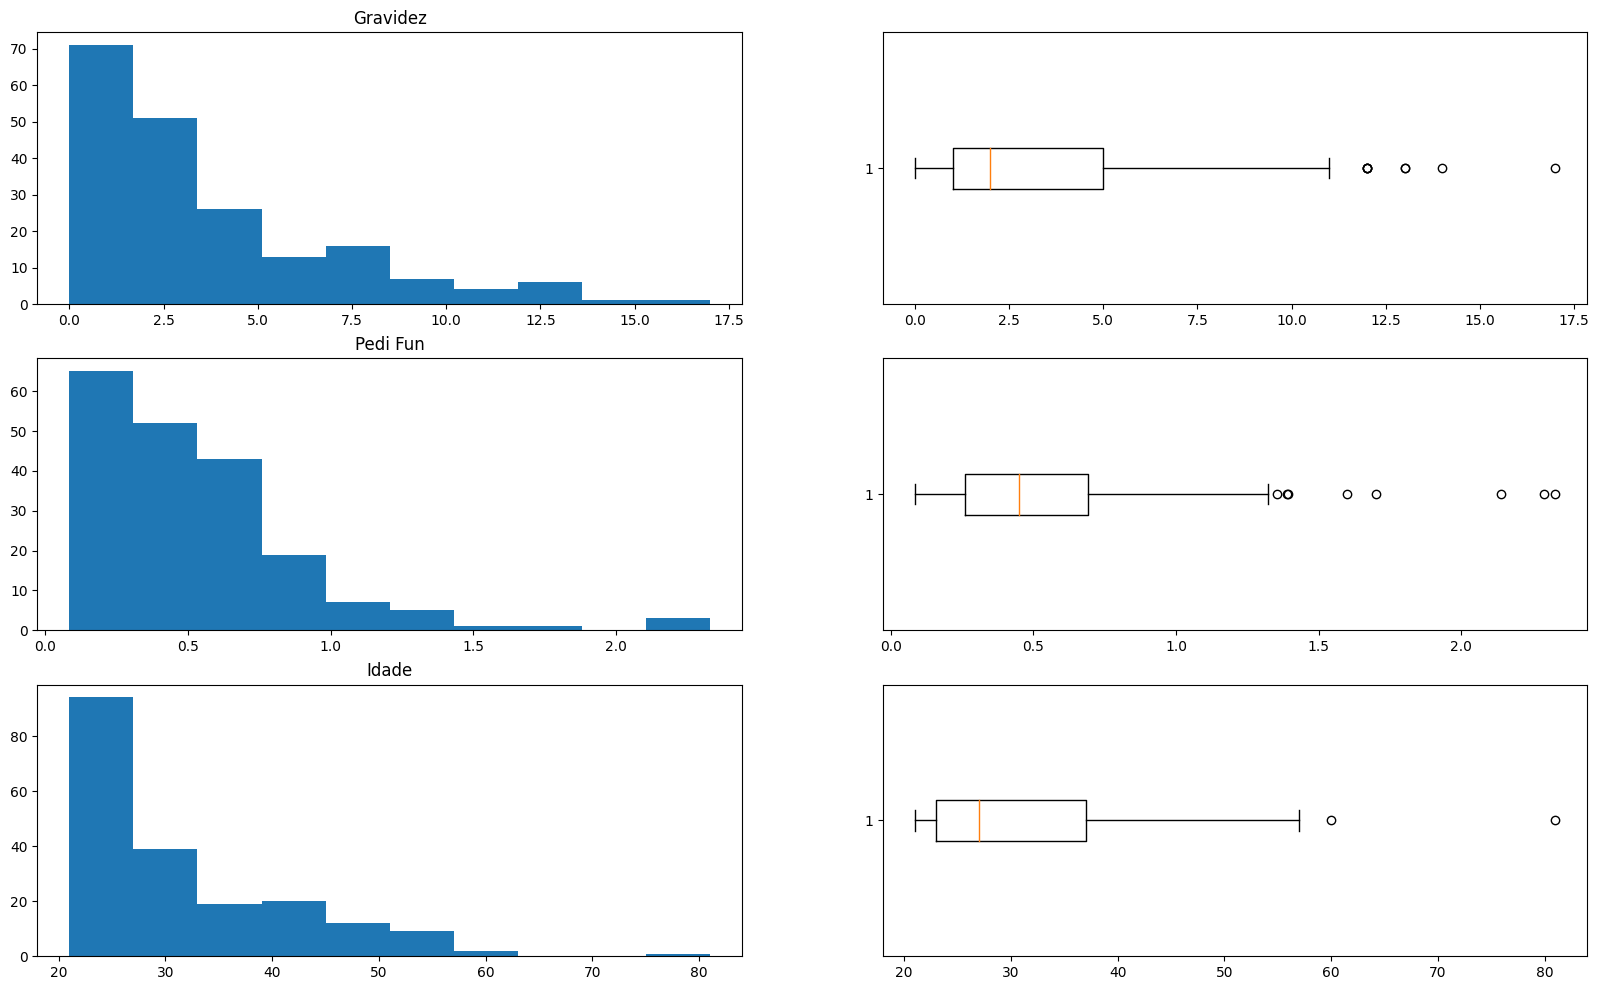

In [21]:
dft = data.copy()
dft = dft.dropna()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 12))

axes[0, 0].hist(dft.Pregnancies, bins=10)
axes[0, 1].boxplot(dft.Pregnancies, vert=False)
axes[0, 0].set_title("Gravidez")

axes[1, 0].hist(dft.DiabetesPedigreeFunction, bins=10)
axes[1, 1].boxplot(dft.DiabetesPedigreeFunction, vert=False)
axes[1, 0].set_title("Pedi Fun")

axes[2, 0].hist(dft.Age, bins=10)
axes[2, 1].boxplot(dft.Age, vert=False)
axes[2, 0].set_title("Idade")

plt.show()

In [22]:
dft = data.copy()
dft = dft[dft.Pregnancies < 11]
df_preg = acumulateTrainTestRuns(dft, 0.8, 'Pregnancies', lambda x: x, -1, -1, 500)
df_preg.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.693841,0.673771,0.526083,0.506917,0.442460,0.423806
std,0.106073,0.100359,0.253343,0.245495,0.232508,0.221304
min,0.333333,0.368421,0.000000,0.000000,0.000000,0.000000
25%,0.631579,0.611111,0.333333,0.333333,0.285714,0.250000
50%,0.700000,0.684211,0.500000,0.500000,0.428571,0.428571
75%,0.777778,0.736842,0.666667,0.666667,0.600000,0.571429
max,0.950000,0.947368,1.000000,1.000000,1.000000,1.000000


In [23]:
dft = data.copy()
dft = dft[dft.Age < 60]
df_age = acumulateTrainTestRuns(dft, 0.8, 'Age', lambda x: x, -1, -1, 500)
df_age.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.673137,0.669833,0.542115,0.526141,0.479323,0.485188
std,0.102001,0.097908,0.218714,0.211795,0.216335,0.224866
min,0.350000,0.350000,0.000000,0.000000,0.000000,0.000000
25%,0.600000,0.600000,0.400000,0.400000,0.333333,0.333333
50%,0.666667,0.666667,0.500000,0.500000,0.500000,0.500000
75%,0.740132,0.750000,0.666667,0.666667,0.625000,0.666667
max,0.950000,0.900000,1.000000,1.000000,1.000000,1.000000


In [24]:
dft = data.copy()
dft = dft[dft.DiabetesPedigreeFunction < 1.2]
df_ped = acumulateTrainTestRuns(dft, 0.8, 'DiabetesPedigreeFunction', lambda x: x, -1, -1, 500)
df_ped.describe()

,Base Accuracy,Mod Accuracy,Base Precision,Mod Precision,Base Recall,Mod Recall
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.684563,0.692994,0.525828,0.540096,0.448729,0.453283
std,0.102087,0.104262,0.235483,0.246057,0.222558,0.221300
min,0.333333,0.388889,0.000000,0.000000,0.000000,0.000000
25%,0.611111,0.631579,0.375000,0.400000,0.285714,0.333333
50%,0.684211,0.700000,0.500000,0.500000,0.428571,0.444444
75%,0.750000,0.761905,0.666667,0.666667,0.600000,0.600000
max,0.947368,0.947368,1.000000,1.000000,1.000000,1.000000


## Prototipagem

In [25]:
data_impr = data.copy()

# Insulina
data_impr['Insulin'] = data_impr['Insulin'].apply(lambda x: boundedRandomGen(x, 50, 350))

# Espessura da pele
data_impr['SkinThickness'] = data_impr['SkinThickness'].apply(lambda x: boundedRandomGen(x, 10, 50))

# Pressão sanguínea
data_impr['BloodPressure'] = data_impr['BloodPressure'].apply(lambda x: boundedRandomGen(x, 45, 110))
data_impr = data_impr[data_impr.BloodPressure >= 40]
data_impr = data_impr[data_impr.BloodPressure <= 125]

# IMC
data_impr['BMI'] = data_impr['BMI'].apply(lambda x: boundedRandomGen(x, 20, 50))
data_impr = data_impr[data_impr.BMI <= 50]

# Glucose
data_impr['Glucose'] = data_impr['Glucose'].apply(lambda x: boundedRandomGen(x, 45, 200))

# Gravidez
#data_impr = data_impr[data_impr.Pregnancies < 11]

# Gravidez
#data_impr = data_impr[data_impr.Age < 60]

# Pedi Fun
#data_impr = data_impr[data_impr.DiabetesPedigreeFunction < 1.2]

data_impr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               566 non-null    int64  
 1   Glucose                   566 non-null    float64
 2   BloodPressure             566 non-null    float64
 3   SkinThickness             566 non-null    float64
 4   Insulin                   566 non-null    float64
 5   BMI                       566 non-null    float64
 6   DiabetesPedigreeFunction  566 non-null    float64
 7   Age                       566 non-null    int64  
 8   Outcome                   566 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 44.2 KB


In [26]:
df_base = data.dropna()
df_mod = data_impr.dropna()

In [27]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 3 to 569
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               196 non-null    int64  
 1   Glucose                   196 non-null    float64
 2   BloodPressure             196 non-null    float64
 3   SkinThickness             196 non-null    float64
 4   Insulin                   196 non-null    float64
 5   BMI                       196 non-null    float64
 6   DiabetesPedigreeFunction  196 non-null    float64
 7   Age                       196 non-null    int64  
 8   Outcome                   196 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 15.3 KB


In [28]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 566 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               566 non-null    int64  
 1   Glucose                   566 non-null    float64
 2   BloodPressure             566 non-null    float64
 3   SkinThickness             566 non-null    float64
 4   Insulin                   566 non-null    float64
 5   BMI                       566 non-null    float64
 6   DiabetesPedigreeFunction  566 non-null    float64
 7   Age                       566 non-null    int64  
 8   Outcome                   566 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 44.2 KB


In [29]:
df_md2 = data.copy()

# Insulina
df_md2['Insulin'] = df_md2['Insulin'].apply(lambda x: boundedRandomGen(x, 50, 350))

# Espessura da pele
df_md2['SkinThickness'] = df_md2['SkinThickness'].apply(lambda x: boundedRandomGen(x, 10, 50))

# Pressão sanguínea
df_md2['BloodPressure'] = df_md2['BloodPressure'].apply(lambda x: boundedRandomGen(x, 45, 110))

# IMC
df_md2['BMI'] = df_md2['BMI'].apply(lambda x: boundedRandomGen(x, 20, 50))

# Glucose
df_md2['Glucose'] = df_md2['Glucose'].apply(lambda x: boundedRandomGen(x, 45, 200))

# Elimina NaN remanescentes
df_md2 = df_md2.dropna()

In [30]:
df_md3 = data.copy()

df_md3 = df_md3[df_md3.BloodPressure >= 40]
df_md3 = df_md3[df_md3.BloodPressure <= 125]
df_md3 = df_md3[df_md3.BMI <= 50]

# Elimina NaN remanescentes
df_md3 = df_md3.dropna()

In [31]:
base = trainTestReport(df_base, 0.8)
mod = trainTestReport(df_mod, 0.8)
md2 = trainTestReport(df_md2, 0.8)
md3 = trainTestReport(df_md3, 0.8)

print(f"Base Accuracy:\t{base[0]}\nMod Accuracy:\t{mod[0]}\nMd2 Accuracy:\t{md2[0]}\nMd3 Accuracy:\t{md3[0]}\n")
print(f"Base Precision:\t{base[1]}\nMod Precision:\t{mod[1]}\nMd2 Precision:\t{md2[1]}\nMd3 Precision:\t{md3[1]}\n")
print(f"Base Recall:\t{base[2]}\nMod Recall:\t{mod[2]}\nMd2 Recall:\t{md2[2]}\nMd3 Recall:\t{md3[2]}")

Base Accuracy:	0.65
Mod Accuracy:	0.6754385964912281
Md2 Accuracy:	0.7043478260869566
Md3 Accuracy:	0.6666666666666666

Base Precision:	0.47058823529411764
Mod Precision:	0.5652173913043478
Md2 Precision:	0.5882352941176471
Md3 Precision:	0.5

Base Recall:	0.6153846153846154
Mod Recall:	0.6046511627906976
Md2 Recall:	0.6976744186046512
Md3 Recall:	0.6153846153846154


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               572 non-null    int64  
 1   Glucose                   567 non-null    float64
 2   BloodPressure             537 non-null    float64
 3   SkinThickness             345 non-null    float64
 4   Insulin                   198 non-null    float64
 5   BMI                       561 non-null    float64
 6   DiabetesPedigreeFunction  572 non-null    float64
 7   Age                       572 non-null    int64  
 8   Outcome                   572 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 40.3 KB


In [33]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,572.000000,567.000000,537.000000,345.000000,198.000000,561.000000,572.000000,572.000000,572.000000
mean,4.106643,121.647266,73.150838,29.356522,156.934343,32.327629,0.459121,34.043706,0.358392
std,3.446995,30.132084,12.347184,10.433503,119.066934,6.735437,0.336124,12.103893,0.479948
min,0.000000,44.000000,30.000000,7.000000,16.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,100.000000,65.000000,22.000000,77.500000,27.500000,0.236000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,30.000000,129.500000,32.000000,0.344500,30.000000,0.000000
75%,6.000000,140.000000,80.000000,36.000000,185.000000,36.600000,0.605500,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,744.000000,57.300000,2.329000,81.000000,1.000000


In [34]:
data.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.077344,0.192716,0.085594,-0.017372,0.025920,-0.031881,0.498979,0.185400
Glucose,0.077344,1.000000,0.201205,0.222645,0.615888,0.222214,0.141548,0.202266,0.480425
BloodPressure,0.192716,0.201205,1.000000,0.160870,0.071659,0.225717,-0.006334,0.317875,0.099409
SkinThickness,0.085594,0.222645,0.160870,1.000000,0.191158,0.625727,0.074387,0.160159,0.252870
Insulin,-0.017372,0.615888,0.071659,0.191158,1.000000,0.282530,0.219553,0.036192,0.274332
BMI,0.025920,0.222214,0.225717,0.625727,0.282530,1.000000,0.139180,-0.006016,0.308132
DiabetesPedigreeFunction,-0.031881,0.141548,-0.006334,0.074387,0.219553,0.139180,1.000000,0.025713,0.171984
Age,0.498979,0.202266,0.317875,0.160159,0.036192,-0.006016,0.025713,1.000000,0.171850
Outcome,0.185400,0.480425,0.099409,0.252870,0.274332,0.308132,0.171984,0.171850,1.000000
